# Explainability AI - Project

Izard Anne-Solène - Cockenpot Louis - Florval Clément - Gauthier Louis

---

ESILV A4 - CDOF4

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np


## Medical Cost Personal Datasets
(https://www.kaggle.com/datasets/mirichoi0218/insurance)

This Kaggle dataset comprises individual insurance costs influenced by various factors like age, sex, BMI, number of children, smoking status, and region.

We are going to try to predict personal insurance charges based on these features, by understanding the impact of personal attributes on insurance costs.

In [2]:
df = pd.read_csv('insurance.csv')
df.head().style.set_caption('First 5 rows of the dataset')


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900000,0,yes,southwest,16884.924000
1,18,male,33.770000,1,no,southeast,1725.552300
2,28,male,33.000000,3,no,southeast,4449.462000
3,33,male,22.705000,0,no,northwest,21984.470610
4,32,male,28.880000,0,no,northwest,3866.855200


In [3]:
df.describe().style.format("{0:.2f}").set_caption("Dataset numerical features description")


,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [4]:
def data_info(df):
    data = {
        'Column Name': df.columns,
        'Data Type': [str(df[col].dtype) for col in df.columns],
        'Non-Null Count': df.count().values
    }

    info_df = pd.DataFrame(data)

    return info_df.style.set_caption('Dataset information')

data_info(df)


,Column Name,Data Type,Non-Null Count
0,age,int64,1338
1,sex,object,1338
2,bmi,float64,1338
3,children,int64,1338
4,smoker,object,1338
5,region,object,1338
6,charges,float64,1338


We have no missing values which is good. We have 3 columns with categorical values. We will convert them to numerical values using one hot encoding. We will also normalize the numerical values using StandardScaler. We will start by using a simple linear regression model to predict the price of the hospital charges.

- children: Number of children covered by health insurance / Number of dependents

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- charges: Individual medical costs billed by health insurance

### Question 3.
Let’s begin with some visualisations.

• Based on your intuition what are the most important variables for predicting your target variable?

• Create visualisations that take into account the type of variable (categorical, numerical) that show
the correlation of the features you selected.

• Don’t forget to clean your dataset as needed in order to deal with missing values and outliers


---


Intuitively, the most influential variables for predicting insurance costs would be `age`, `BMI`, and `smoking status`.

- Age is very correlates with health risk and medical needs.
- A too high/too low BMI (Body Mass Index) is also directly linked to potential diseases.
- Same for smoking status, which is certainely the most obvious correlated variable.


In [5]:
import plotly.express as px


fig = px.histogram(df, x='charges', marginal="violin",
                   title='Charges Distribution',
                   labels={'charges': 'Charges'},
                   nbins= 100)

fig.update_layout(title_text='Charges Distribution', title_x=0.5,
                  title_font=dict(size=18),
                  bargap=0.05)

fig.show()


The KDE (Kernel Density Estimate) is represented by the line tracing the top of the distribution, providing an estimation of the probability density function of the variable.



In [6]:
fig = px.box(df, y='charges', title='Charges Distribution')
# Show plot
fig.show()


Let's try to straighten the curve so that it looks more like a Gaussian distribution.


Let's compute the logarithmes of the charges and plot its distribution

In [7]:
df_temp = df.copy()
df_temp['charges_log'] = np.log(df_temp['charges'])

fig = px.histogram(df_temp, x='charges_log', marginal="violin",
                   title='Log charges Distribution',
                   labels={'charges_log': 'Log charges'},
                   nbins= 100)

fig.update_layout(title_text='Log charges Distribution', title_x=0.5,
                  title_font=dict(size=18),
                  bargap=0.05)
# Show plot
fig.show()



This is much better

Let's plot the correlation matrix for numerical variables

<Axes: >

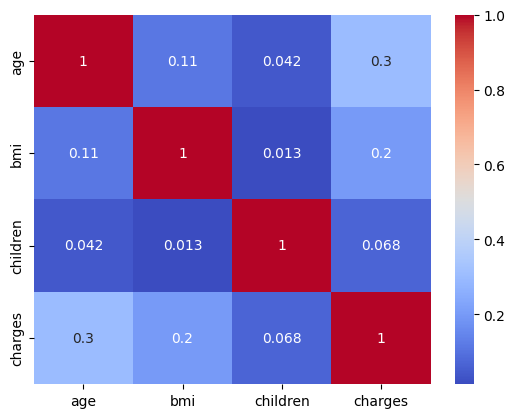

In [8]:
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr(method='pearson')
#plotting the correlation
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)


Cleary the charges are highly correlated with age and bmi. This is expected as older people and people with higher bmi are more likely to have health issues and therefore higher charges.

Other distributions

In [9]:
fig = px.scatter(df, x='bmi', y='charges', title='Charges based on BMI',
                   labels={'bmi': 'BMI', 'charges': 'Charges'}, trendline='ols')

for trace in fig.data:
  if trace.mode == "lines":
    trace.line.color = 'red'

fig.update_layout(title_x=0.5,
                    title_font=dict(size=18))

fig.show()


In [10]:
fig = px.scatter(df, x='age', y='charges', color='smoker', title='Charges vs Age',
                  trendline='ols', color_discrete_map={'yes': 'red', 'no': 'blue'})

fig.update_layout(title_x=0.5,
                    title_font=dict(size=18),
                    xaxis_title='Age',
                    yaxis_title='Charges')


In [11]:
# ADD CHARGES IN COMPARIZON TO SEX

fig = px.pie(df, names ='sex', title= 'Distribution of sex in the data')
fig.show()


Here we can see better than on the graph above the distribution of the charges.

In [12]:
import plotly.express as px

fig = px.scatter_matrix(df,
                        dimensions=df.columns,
                        #color='green',
                        title='Pairplot of the DataFrame')

fig.update_traces(diagonal_visible=False,
                  marker=dict(color='green', opacity=0.7, line=dict(color='#aec6cf', width=1)),
                  showupperhalf=False)

fig.update_layout(
    title_x=0.5,
    title='Pairplot of the DataFrame',
    width=1000,
    height=1000
)

fig.show()


# drop region since its equaly reparted with charges (last graph) ? and not interseting ?

==> OUI

### Question 4.
Let’s do a linear regression.

• Do the variable transformations that are needed (on hot encoding, log etc...)

• Fit the linear regression

• Interpret the coefficients of your regression

• Does any coefficient contradict your intuition?


In [13]:
#one hot encoding on the categorical columns
df = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['bmi'] = scaler.fit_transform(df[['bmi']])
df['age'] = scaler.fit_transform(df[['age']])
df['charges'] = np.log(df['charges'])

df.head(10).style.set_caption("Data for training")


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,0,9.734176,False,True,False,False,True
1,-1.509965,0.509621,1,7.453302,True,False,False,True,False
2,-0.797954,0.383307,3,8.400538,True,False,False,True,False
3,-0.441948,-1.305531,0,9.998092,True,False,True,False,False
4,-0.513149,-0.292556,0,8.260197,True,False,True,False,False
5,-0.584350,-0.807656,0,8.231275,False,False,False,True,False
6,0.483668,0.455486,1,9.016827,False,False,False,True,False
7,-0.157143,-0.479567,3,8.893093,False,False,True,False,False
8,-0.157143,-0.136714,2,8.765054,True,False,False,False,False
9,1.480485,-0.791252,0,10.272397,False,False,True,False,False


In [15]:
from sklearn.model_selection import train_test_split
y = df['charges']
X = df.drop("charges" , axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)


In [16]:
# Linear regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)

y_pred_exp = np.exp(y_pred) # undo log operation
y_test_exp = np.exp(y_test)

mse = mean_squared_error(y_test_exp, y_pred_exp)
mae = mean_absolute_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')



Mean Squared Error: 61079027.74116511
Mean Absolute Error: 3888.7707805158716
R2 Score: 0.6065730962548851


Coefficients interpretation

In [17]:
coeff_df = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
coeff_df.style.set_caption('Model Coefficients')


,Coefficient
smoker_yes,1.551698
age,0.480968
children,0.092448
bmi,0.082903
region_northwest,-0.056414
sex_male,-0.074350
region_southwest,-0.122557
region_southeast,-0.136068


As we can see, the column with the highest coeff is smoker_yes, which is coherent with our intuition. Same for age, as we said earlier, it is a key variable for predicting insurance costs because age is directly correlated with health risk and medical needs.

On the other hand, the BMI coeff is lower than expected. It can be explained by the fact that we can't only the BMI to set insurance costs, there are many other factors to take into account.


### Question 5.
Let’s build a more complex model

• Build the ”best” model you can using traditional data science (no deep learning)

• Don’t hesitate to fine tune it, try different combination of variables etc

• What is the best metric you can reach? Can you consider it ”good”

• Given your results what use case can be done with this model?


Let's use XGBRegressor. We use GridSearchCV for hyperparameter tuning locally.

In [18]:
from xgboost import XGBRegressor

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

xgb = XGBRegressor(eval_metric="mae", early_stopping_rounds=10,
                   colsample_bytree=0.8, learning_rate=0.01,
                   max_depth=5, n_estimators=1000,
                   subsample=0.7)

xgb.fit(X_train_xgb, y_train_xgb,
        eval_set=[(X_test_xgb, y_test_xgb)],
        verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Model evaluation

In [19]:
y_pred = xgb.predict(X_test)

y_pred_exp = np.exp(y_pred) # undo log operation
y_test_exp = np.exp(y_test)

mse = mean_squared_error(y_test_exp, y_pred_exp)
mae = mean_absolute_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


Mean Squared Error: 20656058.091583047
Mean Absolute Error: 2123.694070094507
R2 Score: 0.8669486192054483


### Question 6.
Using shapley values explain your model
- Start by giving some forceplot examples
- Use the feature importance and identify the most important variables
- Compare them to the variables identified in the linear regression
- Using the beeswarm plot explain the model behaviour for the most important variables
- Use dependance plots in order to understand the behaviour of the most important variables

Calculating shapeley values

In [20]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X_test)


**Forceplot examples**

First row

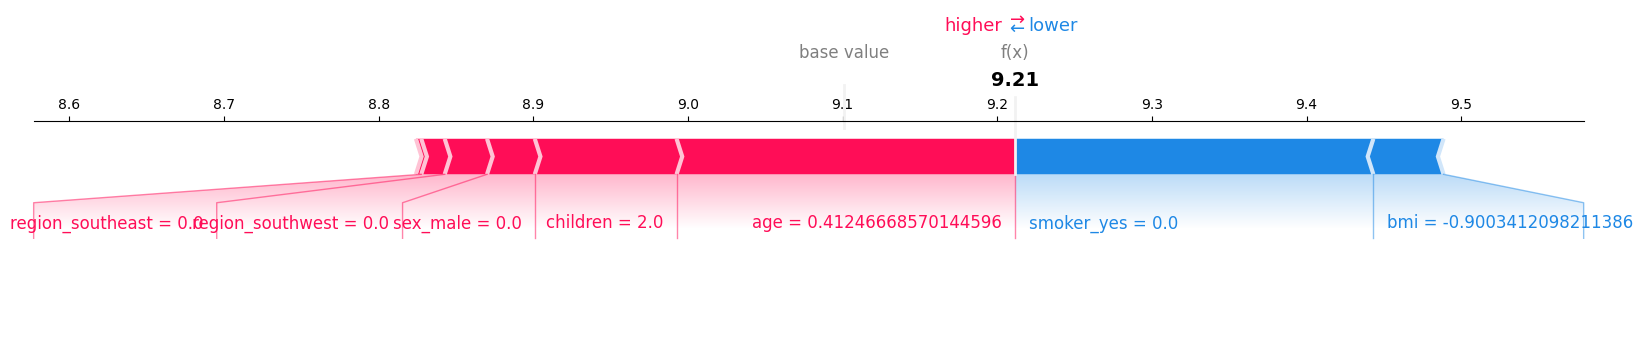

In [21]:
shap.plots.force(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib = True)


We can see that the age of this person has a positive impact on the charges, meaning that this person is not young and is likely to have more health problems.

In the other hand, the fact that this person is not a smoker has a negative impact on the charges.

11th row

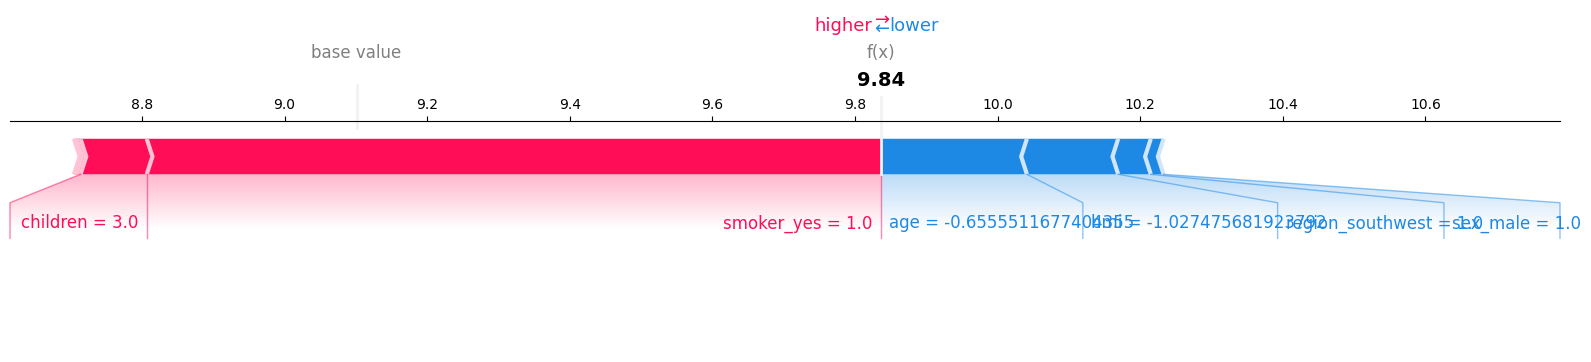

In [22]:
shap.plots.force(explainer.expected_value, shap_values[10], X_test.iloc[10], matplotlib = True)


28th row

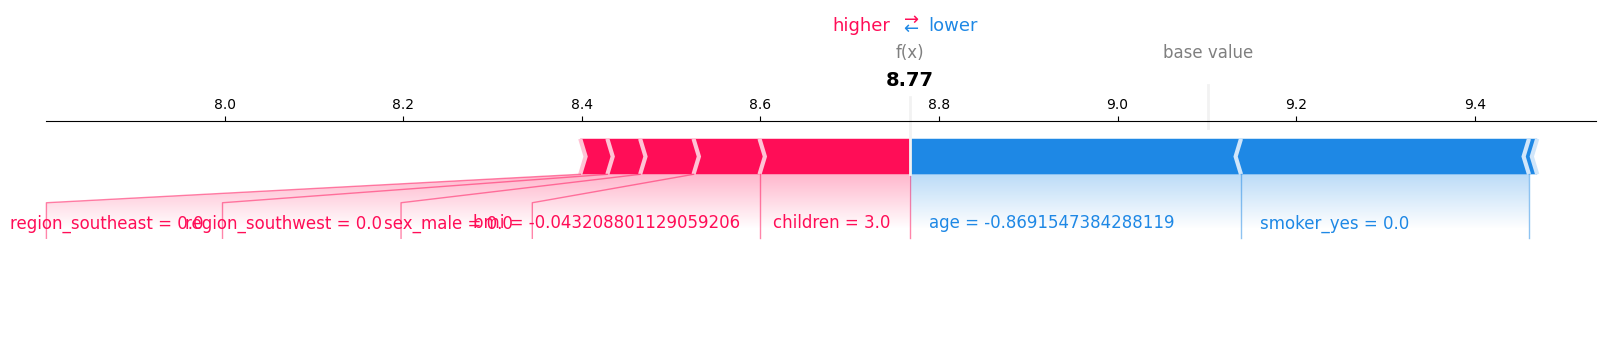

In [23]:
shap.plots.force(explainer.expected_value, shap_values[27], X_test.iloc[27], matplotlib = True)


**Global feature importance**

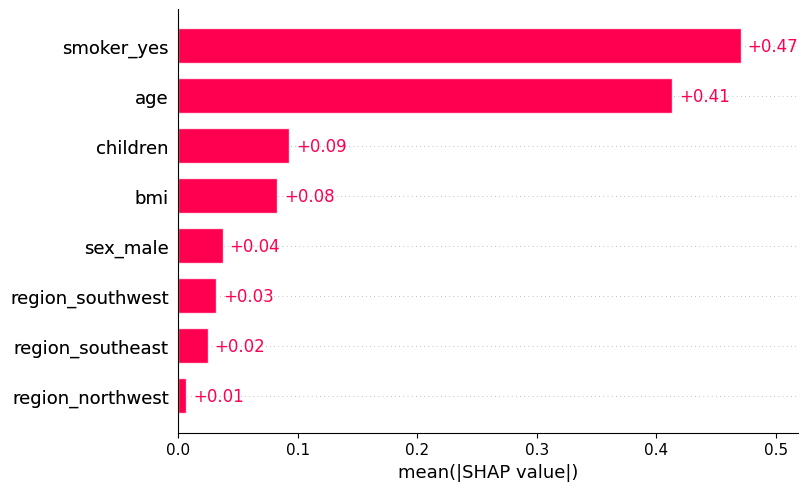

In [24]:
shaps = explainer(X_test)
shap.plots.bar(shaps)


As we can see, the feature importance of this XGBRegressor model is likely the same as the linear regression model. 

The two most important features are smoker_yes and age.

The sex has taken one position compared to the linear regression model, but it is still not very important.

**Beeswarm plot**

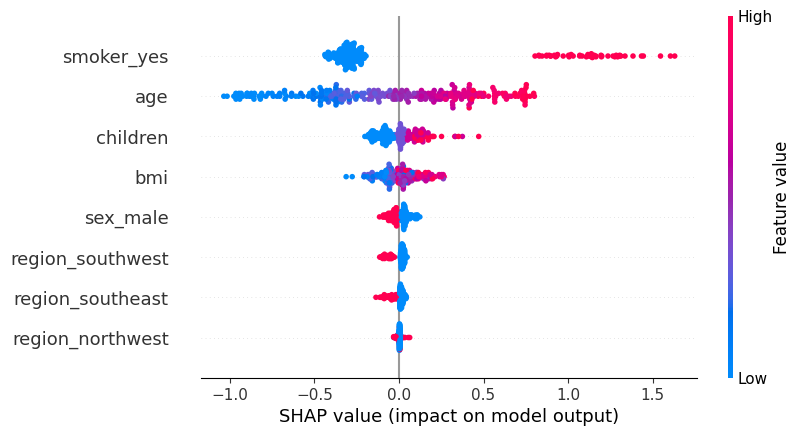

In [25]:
shap.plots.beeswarm(shaps)


**Dependance plots**

For the most important feature: `smoker_yes`

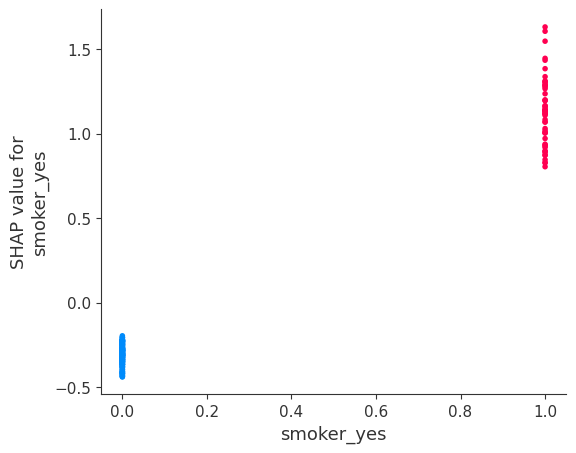

In [26]:
shap.dependence_plot("smoker_yes", shap_values, X_test, interaction_index='smoker_yes')


For the second most important feature: `age`

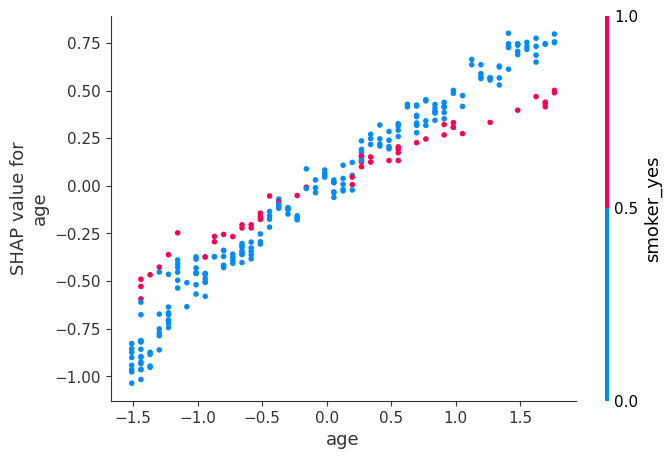

In [28]:
shap.dependence_plot("age", shap_values, X_test, interaction_index='smoker_yes')


`BMI`

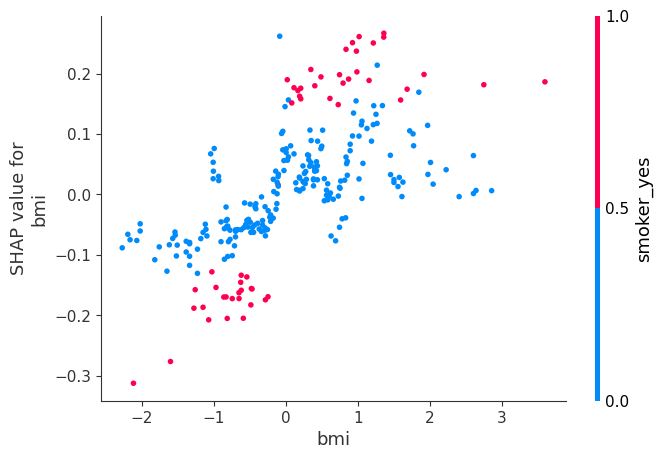

In [29]:
shap.dependence_plot("bmi", shap_values, X_test, interaction_index='smoker_yes')


### Question 7.
We will now do a clusteirng of shapley values.
- Let’s reduce the dimension of our data for visualisation purposes. Do a PCA with the shapley values
and visualise the 2 principal axis.
- Given the visualisation choose a clustering algorithm (K-Means, DBSCAN, gausian mixture...) and
try to cluster the shapley values of the property.
- Visualise your results
- What characteristics can you give to each cluster?
- What conclusion can you reach?
